In [68]:
# !pip install --upgrade pandas_datareader
# !pip install yfinance


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt 
# from pandas_datareader import data as pdr
import yfinance as yf


## Define Stock list

In [159]:
# stock_list = ['CBA', 'BHP', 'TLS', 'MSFT']
# stock_list = ['msft', 'aapl', 'goog']
# stock_list = ['MSFT', 'AAPL', 'GOOG']
stock_list = ['F', 'TSLA', 'BYND', "DIS"]

stock_list = list(map(lambda x: x.lower(), stock_list))

yf_stock_list = " ".join(stock_list)
yf_stock_list

'f tsla bynd dis'

## Yfin Ticker examples 

[*********************100%***********************]  1 of 1 completed


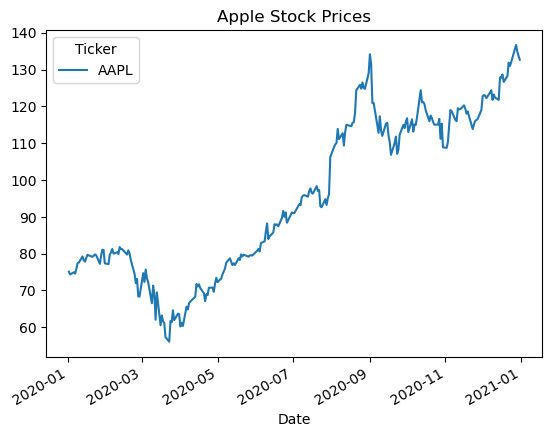

In [436]:
# access each ticker using (example)
# tickers.tickers['MSFT'].info
# tickers.tickers['AAPL'].history(period="1mo")['Close']
# tickers.tickers['GOOG'].actions

data = yf.download("AAPL", start="2020-01-01", end="2021-01-01")
data['Close'].plot()
plt.title("Apple Stock Prices")
plt.show()

In [437]:
data

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-01-02 00:00:00+00:00,72.876114,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03 00:00:00+00:00,72.167618,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06 00:00:00+00:00,72.742661,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07 00:00:00+00:00,72.400536,74.597504,75.224998,74.370003,74.959999,108872000
2020-01-08 00:00:00+00:00,73.565193,75.797501,76.110001,74.290001,74.290001,132079200
...,...,...,...,...,...,...
2020-12-24 00:00:00+00:00,129.189499,131.970001,133.460007,131.100006,131.320007,54930100
2020-12-28 00:00:00+00:00,133.810043,136.690002,137.339996,133.509995,133.990005,124486200


## Get Data

In [160]:
stock_list

['f', 'tsla', 'bynd', 'dis']

In [161]:
def get_means_cov(tickers, stock_list, period="1y"):
    mean_returns = []
    stock_list_data = []

    for stock in stock_list:
        stock_data = tickers.tickers[stock.upper()].history(period=period)["Close"]
        returns = stock_data.pct_change()
        mean_returns.append(returns.mean())
        stock_list_data.append(returns)


    prices_array = np.array(stock_list_data)
    mask = ~np.isnan(prices_array).any(axis=0)  # Find columns without any NaNs

    # Filter the array to keep only columns without NaN values
    filtered_prices = prices_array[:, mask]

    # Calculate the covariance matrix
    cov_matrix = np.cov(filtered_prices)

    # return mean_returns, stock_list_data.cov() 
    return mean_returns, cov_matrix

In [326]:
tickers = yf.Tickers(yf_stock_list)
mean_returns, cov_matrix = get_means_cov(tickers, stock_list)

In [327]:
print(mean_returns)
print(cov_matrix)

[0.0004730736741756978, 0.001477163670471259, 0.001674026866799959, 0.0008384331641948539]
[[5.81060112e-04 1.84675960e-04 2.69235836e-04 8.21001081e-05]
 [1.84675960e-04 1.35951786e-03 4.04913044e-04 8.12437591e-05]
 [2.69235836e-04 4.04913044e-04 2.46841548e-03 1.66526104e-04]
 [8.21001081e-05 8.12437591e-05 1.66526104e-04 2.72124331e-04]]


## MC Sim

In [164]:
# weights is how many percent of portfolio goes into stock
weights = np.random.random(len(mean_returns))
weights /= np.sum(weights)   # normalize weights to sum up to 1 
weights

array([0.30497455, 0.19307496, 0.25667715, 0.24527334])

### MC SIM Vars 

In [165]:
mc_sims = 500
T = 100 # timeframe in days 100 days in code 

mean_matrix = np.full(shape=(T, len(weights)), fill_value=mean_returns)
mean_matrix = mean_matrix.T 

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
initial_portfolio_value = 10000


### MC SIM Loop

In [187]:
for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(cov_matrix)
    daily_returns = mean_matrix + np.inner(L, Z)
    # print(daily_returns)

    # cumulative effect of daily changes 
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initial_portfolio_value

In [226]:
portfolio_sims.shape
print(f'{T} days with {mc_sims} possibilities')

100 days with 500 possibilities


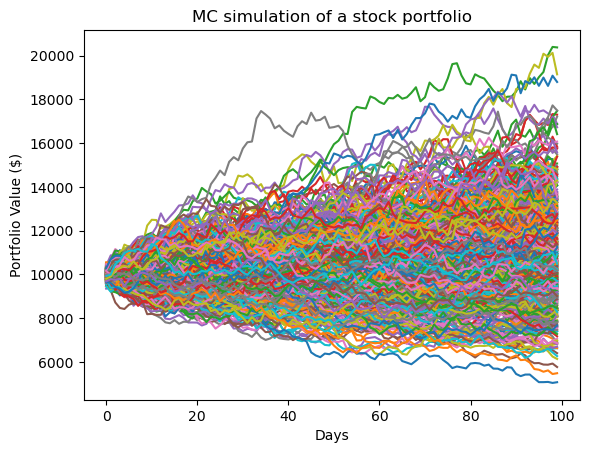

In [230]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

# Markov Chain MC 

## Metropolis Hasting 

We are assuming daily returns are distributed by MVN(\mu, \sigma)

In [ ]:
# https://exowanderer.medium.com/metropolis-hastings-mcmc-from-scratch-in-python-c21e53c485b7

In [248]:
# mean_matrix_mcmc = np.full(shape=(T, len(weights)), fill_value=0.0)
# mean_matrix_mcmc[0,] = mean_returns
# mean_matrix_mcmc.T.shape


### MH Functions

In [358]:
def likelihood(x, mean_matrix, cov_matrix):
    # Standard Normal Distribution
    # An underlying assumption of linear regression is that the residuals
    # are Gaussian Normal Distributed; often, Standard Normal distributed
    # return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

    # MVN 
    mu = mean_matrix
    sigma = cov_matrix
    p = len(mean_matrix) # number of param

    diff = x - mu
    mahalanobis_distance = np.dot(np.dot(diff, np.linalg.inv(sigma)), diff.T)

    # print("CALLED")
    # print(mahalanobis_distance)

    return ((2*np.pi)**(p/2)) * (np.linalg.det(sigma)**(-0.5)) * np.exp(-0.5* mahalanobis_distance) 


In [359]:
def proposal_distribution(mu, sigma):
    # Select the proposed state (new guess) from a Gaussian distribution
    #  centered at the current state, within a Guassian of width `stepsize`
    # p = len(mu)
    p = mu.shape[1]
    Z = np.random.normal(size=(1,p))
    L = np.linalg.cholesky(sigma)
    metro_step = mu + np.dot(Z, L)  # daily returns 
    return metro_step

In [360]:
def mcmc_updater(curr_state, curr_likeli, 
                 likelihood, proposal_distribution, mu, sigma):
  """ Propose a new state and compare the likelihoods

  Given the current state (initially random), 
    current likelihood, the likelihood function, and 
    the transition (proposal) distribution, `mcmc_updater` generates 
    a new proposal, evaluate its likelihood, compares that to the current 
    likelihood with a uniformly samples threshold, 
  then it returns new or current state in the MCMC chain.

  Args:
      curr_state (float): the current parameter/state value
      curr_likeli (float): the current likelihood estimate
      likelihood (function): a function handle to compute the likelihood
      proposal_distribution (function): a function handle to compute the 
        next proposal state

  Returns:
      (tuple): either the current state or the new state
        and its corresponding likelihood
  """
  # Generate a proposal state using the proposal distribution
  # Proposal state == new guess state to be compared to current
  proposal_state = proposal_distribution(mu=curr_state, sigma=sigma)

  # Calculate the acceptance criterion
  prop_likeli = likelihood(proposal_state, mu, sigma)
  accept_crit = prop_likeli / curr_likeli

  # Generate a random number between 0 and 1
  accept_threshold = np.random.uniform(0, 1)


  # If the acceptance criterion is greater than the random number,
  # accept the proposal state as the current state
  if accept_crit > accept_threshold:
      return proposal_state, prop_likeli

  # Else
  return curr_state, curr_likeli

In [421]:
def metropolis_hastings(
        likelihood, proposal_distribution, initial_state, 
        num_samples, mu=mean_matrix,  sigma=cov_matrix, burnin=0.2):
    """ Compute the Markov Chain Monte Carlo

    Args:
        likelihood (function): a function handle to compute the likelihood
        proposal_distribution (function): a function handle to compute the 
          next proposal state
        initial_state (list): The initial conditions to start the chain
        num_samples (integer): The number of samples to compte, 
          or length of the chain
        stepsize: is basically sigma 
        burnin (float): a float value from 0 to 1.
          The percentage of chain considered to be the burnin length

    Returns:
        samples (list): The Markov Chain,
          samples from the posterior distribution
    """
    samples = []

    # The number of samples in the burn in phase
    idx_burnin = int(burnin * num_samples)

    # Set the current state to the initial state
    curr_state = initial_state
    curr_likeli = likelihood(curr_state, mu, sigma)

    for i in range(num_samples):
        # The proposal distribution sampling and comparison
        #   occur within the mcmc_updater routine
        curr_state, curr_likeli = mcmc_updater(
            curr_state=curr_state,
            curr_likeli=curr_likeli,
            likelihood=likelihood,
            proposal_distribution=proposal_distribution,
            mu=mu,
            sigma=sigma
        )

        # Append the current state to the list of samples
        if i >= idx_burnin:
            # Only append after the burnin to avoid including
            #   parts of the chain that are prior-dominated
            samples.append(curr_state)

            # daily_returns = curr_state
            # portfolio_sims[:,i-idx_burnin] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initial_portfolio_value

    return np.array(samples)


### MH SIM

In [422]:
mcmc_chains = 500
mcmc_sims = 20000 
burnin = 0.5

# sim timeframe
T = 100 # timeframe in days 100 days in code

# mean_matrix_mcmc = np.full(shape=(T, len(weights)), fill_value=0.0)
# # mean_matrix_mcmc 
# mean_matrix_mcmc = mean_matrix_mcmc.T 

portfolio_sims_mcmc = np.full(shape=(T, int((1-burnin)*mcmc_sims)), fill_value=0.0)
initial_portfolio_value = 10000

np.random.seed(42)

mean_returns_mcmc = np.array(mean_returns)
mean_returns_mcmc = mean_returns_mcmc.reshape(1, 4)
initial_state = np.array([0 for _ in range(len(weights))]).reshape(1,4)  # Trivial case, starting at the mode of the likelihood

In [423]:
samples = metropolis_hastings(
    likelihood,
    proposal_distribution,
    initial_state,
    mcmc_sims,
    mu=mean_returns,
    sigma=cov_matrix,
    burnin=burnin
)

# samples

In [416]:
np.array(samples).shape


(10000, 1, 4)

In [424]:
samples

array([[[-0.0402301 , -0.00474185,  0.05936639, -0.01599997]],

       [[-0.0402301 , -0.00474185,  0.05936639, -0.01599997]],

       [[ 0.00889575,  0.00246674,  0.05483935,  0.01712994]],

       ...,

       [[-0.01913545,  0.02592253, -0.00346492, -0.00171345]],

       [[-0.01913545,  0.02592253, -0.00346492, -0.00171345]],

       [[ 0.00110629,  0.03026395, -0.03167862, -0.00909523]]])

In [425]:
samples[:,0,:].shape

(10000, 4)

In [426]:
portfolio_sims[:,0].shape


(100,)

In [427]:
samples[:T, 0,].shape

(100, 4)

In [429]:
weights

array([0.30497455, 0.19307496, 0.25667715, 0.24527334])

In [430]:
daily_returns = samples[:T, 0,]

In [435]:
daily_returns

array([[-4.02300999e-02, -4.74185367e-03,  5.93663908e-02,
        -1.59999684e-02],
       [-4.02300999e-02, -4.74185367e-03,  5.93663908e-02,
        -1.59999684e-02],
       [ 8.89574933e-03,  2.46674362e-03,  5.48393490e-02,
         1.71299438e-02],
       [ 8.89574933e-03,  2.46674362e-03,  5.48393490e-02,
         1.71299438e-02],
       [ 1.07270561e-02,  4.10162559e-02,  7.21351507e-02,
         8.25805458e-03],
       [ 4.16812451e-02,  2.37191510e-02,  5.44629983e-02,
         1.21526543e-02],
       [ 4.16812451e-02,  2.37191510e-02,  5.44629983e-02,
         1.21526543e-02],
       [ 2.26614006e-02, -1.40959199e-02,  5.11511078e-02,
         7.55681369e-03],
       [ 2.26614006e-02, -1.40959199e-02,  5.11511078e-02,
         7.55681369e-03],
       [ 1.10442556e-02, -3.10586287e-03,  6.96454609e-03,
         1.31616914e-02],
       [ 1.10442556e-02, -3.10586287e-03,  6.96454609e-03,
         1.31616914e-02],
       [ 4.16778219e-02,  3.43834146e-02,  6.96835650e-02,
      

In [433]:
portfolio_sims_mcmc[:,0] = np.cumprod(np.inner(weights, daily_returns)+1)*initial_portfolio_value

In [405]:
portfolio_sims_mcmc.shape

(100, 500)

In [ ]:
portfolio_sims[:,0] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initial_portfolio_value

In [ ]:
# # MC Sim Loop 
# for m in range(0, mcmc_sims):
#     Z = np.random.normal(size=(T, len(weights)))
#     L = np.linalg.cholesky(cov_matrix)
#     daily_returns = mean_matrix + np.inner(L, Z)

#     # cumulative effect of daily changes 
#     portfolio_sims[:,m] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initial_portfolio_value

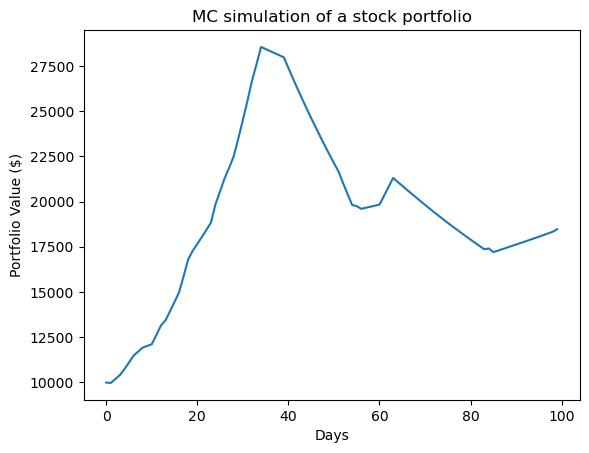

In [434]:
plt.plot(portfolio_sims_mcmc[:,0])
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()